In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from datetime import date, timedelta
import re
from prophet import Prophet
import calendar

In [2]:
path="C:/Users/usuario/Documents/ABDataChallenge/"

In [3]:
def read_csvfile(path,folder,file,skip_rows,skip_fotter,s):
    ## Lectura de ficheros csv (sep=, ), en este caso son los ficheros obtenidos por fuentes públicas (INE)
    path_extension=''
    if folder!="":
        for fd in folder:
            path_extension+=fd+'/'
    path_extension+=file
    df = pd.read_csv(path+path_extension,skiprows=skip_rows,skipfooter=skip_fotter,sep=s)
    return df

def read_xlxs(path,folder,file,skip_rows,skip_fotter):
    ## Lectura de ficheros xlsx, en este caso son los ficheros proporcionados por AB
    path_extension=''
    if folder!="":
        for fd in folder:
            path_extension+=fd+'/'
    path_extension+=file
    df = pd.read_excel(path+path_extension,skiprows=skip_rows,skipfooter=skip_fotter)
    return df

def read_json(path,folder,file):
    path_extension=''
    for fd in folder:
        path_extension+=fd+'/'
    path_extension+=file
    gdf = pd.read_json(path+path_extension)
    return gdf


In [4]:
def week_of_month(tgtdate):
   
    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we cause the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

In [5]:
def matching_ds_data(s_ds,e_ds,list_cod_mun,column):
    data_values=[]
    r_dias=pd.date_range(s_ds,e_ds-timedelta(days=1),freq='d')
    for cod_mun in list_cod_mun:
        for dia in r_dias:
            data_values.append([cod_mun,dia.to_numpy(),0])    
    return pd.DataFrame(data=data_values,columns=["cod_mun","ds",column])

In [6]:
def date_conversion(fecha,split_s):
    array_fecha=fecha.split(split_s)
    return date(int(array_fecha[2]),int(array_fecha[1]),int(array_fecha[0]))

In [7]:
def redo_string(s):
    string = re.sub(r"\ +", '', s)
    return string

In [8]:
def rank_renta(renta,df_describe):
    if renta<df_describe[df_describe["index"]=="25%"].values[0][1]:
        return 1
    elif df_describe[df_describe["index"]=="25%"].values[0][1]<=renta and renta<df_describe[df_describe["index"]=="50%"].values[0][1]:
        return 2
    elif df_describe[df_describe["index"]=="50%"].values[0][1]<=renta and renta<df_describe[df_describe["index"]=="75%"].values[0][1]:
        return 3
    else:
        return 4

In [9]:
def trnf_renta(df):

    df.rename(columns = {' ':'Territorio'}, inplace = True)

    #Selecciono només aquelles localitzacions que pertanyen a seccions
    df['Territorio'].replace('', np.nan, inplace=True)
    df.replace('.', np.nan, inplace=True)
    df.dropna(subset=['Territorio'], inplace=True)

    #Faig una extracció de l'identificador únic per secció anomenat CUSEC que esta dintre de la columna Location
    df[['cod_mun','nom_mun']] = df.Territorio.str.split(" ",expand=True,n=1)

    df[['cod_mun','nom_mun']] = df.Territorio.str.split(" ",expand=True,n=1)
    new_df=df[df.cod_mun.apply(lambda x: len(str(x))==5)]
    

    return new_df.drop(["Territorio"],axis=1)


In [10]:
def string_to_float(s):
    try:
        list_s=s.split(",")
        return float(list_s[0].replace(".", ""))
    except:
        return s
    
def trnf_dpfi(df):
    df=df[(df.Distritos.isna())&(df.Secciones.isna())]
    new_df=df[df["Periodo"].isin([2019,2020])][["Municipios","Distribución por fuente de ingresos","Periodo","Total"]]
    new_df[['cod_mun','nom_mun']] = new_df.Municipios.str.split(" ",expand=True,n=1)
    new_df.drop(["Municipios"],axis=1,inplace=True)
    df['Total'].replace('.', np.nan, inplace=True)
    new_df["Total_num"]=new_df.apply(lambda x: string_to_float(x['Total']), axis=1)
    new_df["Total_num"]=new_df["Total_num"].replace(".",np.nan)
    return new_df

def prctg_distribucion(df):
    
    columns_op=['Fuente de ingreso: otras prestaciones','Fuente de ingreso: otros ingresos', 'Fuente de ingreso: pensiones',
             'Fuente de ingreso: prestaciones por desempleo','Fuente de ingreso: salario', 'Renta bruta media por persona']
    columns=['cod_mun', 'nom_mun','Periodo','Renta bruta media por persona']
    
    df_op=df[columns_op]
    df_op=df_op[['Fuente de ingreso: otras prestaciones','Fuente de ingreso: otros ingresos', 'Fuente de ingreso: pensiones',
             'Fuente de ingreso: prestaciones por desempleo','Fuente de ingreso: salario',]].div(df['Renta bruta media por persona'], axis=0)*100
    df_op=np.round(df_op, decimals=2)
    new_df=pd.concat([df[columns],df_op], axis=1, sort=False)
    return new_df

In [11]:
def trnf_indGini(df):
    new_df=df[(df["Distritos"].isna())&(df["Secciones"].isna())]
    new_df[['cod_mun','nom_mun']] = new_df.Municipios.str.split(" ",expand=True,n=1)
    new_df.drop(["Municipios","Distritos","Secciones"], axis=1,inplace=True)
    new_df_pivot = pd.pivot_table(new_df, values='Total', index=['cod_mun','nom_mun','Periodo'],
                                     columns=['Índice de Gini y Distribución de la renta P80/P20'], aggfunc=np.sum).reset_index()
    return new_df_pivot.reset_index(drop=True)

In [12]:
def trnf_indDmg(df):
    new_df=df[(df["Distritos"].isna())&(df["Secciones"].isna())]
    new_df[['cod_mun','nom_mun']] = new_df.Municipios.str.split(" ",expand=True,n=1)
    new_df.drop(["Municipios","Distritos","Secciones"], axis=1,inplace=True)
    new_df_pivot = pd.pivot_table(new_df, values='Total', index=['cod_mun','nom_mun','Periodo'],
                                     columns=['Indicadores demográficos'], aggfunc=np.sum).reset_index()
    return new_df_pivot

In [13]:
def melt_df(df):
    return pd.melt(df, id_vars=['cod_mun'], value_vars=np.delete(df.columns.values,0),var_name='intervalo_edat', value_name='value')

def group_age(df):
    drop_columns=np.delete(df.columns,-1)

    df["juvenil"]=df["0-4"]+df["5-9"]+df["10-14"]+df["15-19"]
    df["adulto-junior"]=df["20-24"]+df["25-29"]+df["30-34"]+df["35-39"]
    df["adulto-senior"]=df["40-44"]+df["45-49"]+df["50-54"]+df["55-59"]
    df["anciano"]=df["60-64"]+df["65-69"]+df["70-74"]+df["75-79"]+df["80-84"]+df["85-89"]+df["90-94"]+df["95-99"]+df["100 y más"]

    df.drop(drop_columns,axis=1,inplace=True)
    return df

def trnf_transformacion(df):
    df.rename(columns = {' ':'CUSEC'}, inplace = True)
    df.drop(columns=['Total'], inplace = True)
    df["CUSEC"]=df.apply(lambda x: redo_string(x["CUSEC"]), axis=1)

    df=df[df["CUSEC"]!='TOTAL']
    df.reset_index(drop=True,inplace=True)

    idx_h=df[df["CUSEC"]=="Hombres"].index[0] 
    idx_m=df[df["CUSEC"]=="Mujeres"].index[0]

    df_h=df.iloc[idx_h+1:idx_m]
    df_h["cod_mun"]=df_h.CUSEC.str[0:5]
    df_h.drop(["CUSEC"],axis=1,inplace=True)
    df_h_mun=df_h.groupby(df_h.columns.tolist()).sum().reset_index()
    df_h_mumG=group_age(df_h_mun)
    df_h_munMelt=melt_df(df_h_mumG)
    df_h_munMelt["genero"]="hombre"
    
    df_m=df.iloc[idx_m+1:]
    df_m["cod_mun"]=df_m.CUSEC.str[0:5]
    df_m.drop(["CUSEC"],axis=1,inplace=True)
    df_m_mun=df_m.groupby(df_m.columns.tolist()).sum().reset_index()
    df_m_mumG=group_age(df_m_mun)
    df_m_munMelt=melt_df(df_m_mumG)
    df_m_munMelt["Genero"]="mujer"
    
    df_poblacion=pd.concat([df_h_munMelt,df_m_munMelt],ignore_index=True)
   
    
    return df_poblacion

In [14]:
"""
def trnf_dataConsumo(df):
    df=df[df.CONSUMO > 0]
    _,bp = pd.DataFrame.boxplot(df.CONSUMO, return_type='both')
    outliers = [flier.get_ydata() for flier in bp["fliers"]]
    df=df[df.CONSUMO < min(outliers[0])]
    df["ds"]=pd.to_datetime(df.FECHA, errors='coerce')
    df=df[["ds","ID_CONTADOR","CONSUMO"]]
    df=df.sort_values("ds")
    df['week'] = df["ds"].apply(week_of_month)
    df["year"]=df.ds.dt.year
    df["month"]=df.ds.dt.month
    df["day"]=df.ds.dt.day
    df["start_day"]= df.groupby(['year','month','week'])['day'].transform('min')
    df.drop(['ds','day'],axis=1,inplace=True)
    df=df.groupby(["ID_CONTADOR","year","month","week","start_day"]).sum().reset_index()
    df["ds"]=df["start_day"].astype(str)+"-"+df["month"].astype(str)+"-"+df["year"].astype(str)
    df["ds"]= pd.to_datetime(df["ds"], format='%d-%m-%Y', errors='coerce')
    df=df[["ds","ID_CONTADOR","CONSUMO"]]
    return df
"""

In [44]:
"""
def trnf_dataConsumo(df,group_column,remove_outliers=True):
    df=df[df.CONSUMO > 0]
    _,bp = pd.DataFrame.boxplot(df.CONSUMO, return_type='both')
    outliers = [flier.get_ydata() for flier in bp["fliers"]]
    if remove_outliers:
        df=df[df.CONSUMO < min(outliers[0])]
    df["ds"]=pd.to_datetime(df.FECHA, errors='coerce')
    df=df[["ds",group_column,"CONSUMO"]]
    df=df.sort_values("ds")
    df['week'] = df["ds"].apply(week_of_month)
    df["year"]=df.ds.dt.year
    df["month"]=df.ds.dt.month
    df["day"]=df.ds.dt.day
    df["start_day"]= df.groupby(['year','month','week'])['day'].transform('min')
    df.drop(['ds','day'],axis=1,inplace=True)
    df=df.groupby([group_column,"year","month","week","start_day"]).sum().reset_index()
    df["ds"]=df["start_day"].astype(str)+"-"+df["month"].astype(str)+"-"+df["year"].astype(str)
    df["ds"]= pd.to_datetime(df["ds"], format='%d-%m-%Y', errors='coerce')
    df=df[["ds",group_column,"CONSUMO"]]
    return df
"""

In [71]:

def trnf_dataConsumo(df,group_column,remove_outliers=True):
    df=df[df.CONSUMO > 0]
    _,bp = pd.DataFrame.boxplot(df.CONSUMO, return_type='both')
    outliers = [flier.get_ydata() for flier in bp["fliers"]]
    if remove_outliers:
        df=df[df.CONSUMO < min(outliers[0])]
    df["ds"]=pd.to_datetime(df.FECHA, errors='coerce')
    df=df[["ds","CONSUMO"]+group_column]
    df=df.sort_values("ds")
    df['week'] = df["ds"].apply(week_of_month)
    df["year"]=df.ds.dt.year
    df["month"]=df.ds.dt.month
    df["day"]=df.ds.dt.day
    df["start_day"]= df.groupby(['year','month','week'])['day'].transform('min')
    df.drop(['ds','day'],axis=1,inplace=True)
    df=df.groupby(group_column+["year","month","week","start_day"]).sum().reset_index()
    df["ds"]=df["start_day"].astype(str)+"-"+df["month"].astype(str)+"-"+df["year"].astype(str)
    df["ds"]= pd.to_datetime(df["ds"], format='%d-%m-%Y', errors='coerce')
    df=df[["ds","CONSUMO"]+group_column]
    return df


In [81]:
def concatenate_Data(root_path,info_data,dfMunAABData,df_poblacion=None):
    df=pd.DataFrame([])
    with os.scandir(root_path) as directory:
        for file in directory:
            ###
            full_path=root_path+file.name
            split_file=file.name.split("_")
            extension=split_file[-1].split(".")
            if len(extension) > 2:
                nom_mun=''
                for i in range(len(extension)-1):
                    ext+=extension[i]
            else:
                ext=extension[0]

            if info_data=="Tipo_Consumo":
                #df_consumo=pd.read_csv('C:/Users/usuario/Documents/ABDataChallenge/ABData/TipoConsumo/Uso_Domestico/GAVA.csv')
                df_Mun=read_csvfile(full_path,'','',0,0,",")
                df_Mun=trnf_dataConsumo(df_Mun,["ID_CONTADOR"],True)               
                df_Mun["Nom_Mun"]=ext
                
            elif info_data=="AE_Consumo":
                df_Mun=read_csvfile(full_path,'','',0,0,",")
                df_Mun=df_Mun.rename(columns={"CONSUM": "CONSUMO"})
                df_Mun=trnf_dataConsumo(df_Mun,["EPIGRAF","DESCP EPIGRAF","ID_CLIENTE"],False) 
                df_Mun["Nom_Mun"]=ext
            
            elif info_data=="ConsumoTerritorial":
                df_Mun=read_csvfile(full_path,'','',0,0,",")
                df_Mun=df_Mun.rename(columns={"CONSUM": "CONSUMO"})
                df_Mun=trnf_dataConsumo(df_Mun,["ZONA"],False)
                
            elif info_data=="Renta":
                df_Mun=read_xlxs(full_path,'','',6,9)
                df_Mun=trnf_renta(df_Mun)
                df_Mun["Renta neta media por hogar"]=df_Mun["Renta neta media por hogar"].astype(np.float64)
                df_Mun=df_Mun[df_Mun.cod_mun.isin(dfMunABData.cod_mun.values)].reset_index(drop=True)
                df_Mun["year"]=ext
                
            elif info_data=="PrecioAgua":
                df_Mun=read_xlxs(full_path,'','',11,0)
                df_Mun=df_Mun[["Idescat","TOTAL\n€/m3"]]
                df_Mun=df_Mun.rename(columns={"Idescat": "cod_mun","TOTAL\n€/m3":"precio_agua"})
                df_Mun["cod_mun"]=df_Mun["cod_mun"].apply(lambda x: '{0:0>6}'.format(x))
                df_Mun["cod_mun"]=df_Mun["cod_mun"].str[:5]
                df_Mun=df_Mun[df_Mun.cod_mun.isin(dfMunABData.cod_mun.values)]
                df_Mun["year"]=ext
                
            else:
                df_Mun=read_xlxs(full_path,'','',6,6)
                df_Mun=trnf_transformacion(df_Mun)
                df_Mun=df_Mun[df_Mun.cod_mun.isin(dfMunABData.cod_mun.values)]
                df_Mun["year"]=ext
                
            if df.empty:
                df=df_Mun
            else:
                df=pd.concat([df, df_Mun], ignore_index=True)  
            
    return df

In [73]:
def getting_data(root_path,info_data,dfMunABData,folders_inside=False):
    if folders_inside:
        df=pd.DataFrame([])
        with os.scandir(root_path) as directory:
            for folder in directory:
                parent_path=root_path+folder.name+"/"
                df_folder=concatenate_Data(parent_path,info_data)
                if df.empty:
                    df=df_folder
                else:
                    df=pd.concat([df,df_folder])
                    
        return df    
                
    else:
        return concatenate_Data(root_path,info_data,dfMunABData)
    

### CONSUMO DOMESTICO (hecho)

In [ ]:
### Domestico
df_TCD=getting_data("C:/Users/usuario/Documents/ABDataChallenge/ABData/TipoConsumo/Uso_Domestico/","Tipo_Consumo","",False)

### CONSUMO Comercial (hecho)

In [ ]:
### Comercial
df_TCC=getting_data("C:/Users/usuario/Documents/ABDataChallenge/ABData/TipoConsumo/Consumo_COMERCIAL/","Tipo_Consumo","",False)
df_TCC.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/ConsumoComercial.csv")

### CONSUMO Industrial (hecho)

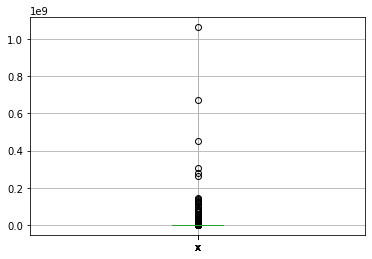

In [57]:
df_TCI=getting_data("C:/Users/usuario/Documents/ABDataChallenge/ABData/TipoConsumo/Consumo_INDUSTRIAL/","Tipo_Consumo","",False)
df_TCI.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/ConsumoIndustrial.csv")

### ActividadEconomica (Hay que ejecutar)

<ipython-input-71-74dae01244ee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ds"]=pd.to_datetime(df.FECHA, errors='coerce')
<ipython-input-71-74dae01244ee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ds"]=pd.to_datetime(df.FECHA, errors='coerce')
<ipython-input-71-74dae01244ee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

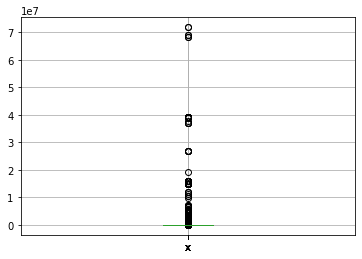

In [84]:
df_AE=getting_data("C:/Users/usuario/Documents/ABDataChallenge/ABData/Actividad_Economica/","AE_Consumo","",False)
df_AE.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/Consumo_AE.csv")

In [77]:
df_AE

,ds,CONSUMO,EPIGRAF,DESCP EPIGRAF,ID_CLIENTE,Nom_Mun
0,2021-05-24,36,A039,Altres activitats relacionades amb la música,285,BADALONA
1,2021-05-31,26,A039,Altres activitats relacionades amb la música,285,BADALONA
2,2021-06-01,251,A039,Altres activitats relacionades amb la música,285,BADALONA
3,2021-06-07,154,A039,Altres activitats relacionades amb la música,285,BADALONA
4,2021-06-14,200,A039,Altres activitats relacionades amb la música,285,BADALONA
...,...,...,...,...,...,...
630833,2021-11-22,215,P887,Maquilladors i esteticistes,131,VILADECANS
630834,2021-11-29,92,P887,Maquilladors i esteticistes,131,VILADECANS
630835,2021-12-01,316,P887,Maquilladors i esteticistes,131,VILADECANS
630836,2021-12-06,221,P887,Maquilladors i esteticistes,131,VILADECANS


In [83]:
df_AE[df_AE.Nom_Mun=="BARCELONA"].CONSUMO.sum()

4323168928

In [79]:
b=pd.read_csv("C:/Users/usuario/Documents/ABDataChallenge/ABData/Actividad_Economica/ConsumPerActivitat_BARCELONA.csv")

In [80]:
b[b.CONSUMO > 0].CONSUMO.sum()

4323168928

### PorTerritorio (Hay que ejecutar)

            FECHA                 ZONA  CONSUMO
0      2019-01-01             SANT BOI    12036
1      2019-01-01  TORRELLES LLOBREGAT      332
2      2019-01-01             BADALONA    24885
3      2019-01-01                 GAVA      385
4      2019-01-01             CORNELLA    17933
...           ...                  ...      ...
29171  2021-12-14                TIANA     7430
29172  2021-12-14               BEGUES      397
29173  2021-12-14  STA.COLOMA GRAMENET      627
29174  2021-12-14  L'HOSPITALET LLOBR.      584
29175  2021-12-14           VILADECANS      483

[29176 rows x 3 columns]


<ipython-input-44-93d3dc00ab73>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ds"]=pd.to_datetime(df.FECHA, errors='coerce')


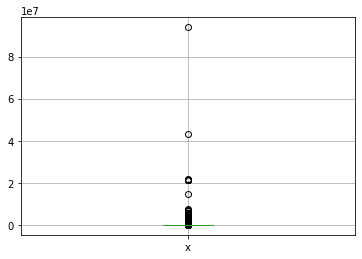

In [61]:
###ConsumoPorTerritorio(Municipio)
df_CPTM=getting_data("C:/Users/usuario/Documents/ABDataChallenge/ABData/ConsumoPorTerritorio/","ConsumoTerritorial","",False)
df_CPTM.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/ConsumoTerritorial.csv")

In [51]:
df_CPTM[df_CPTM.ZONA=="BARCELONA"].sort_values(["ZONA","ds"]).head(20)

,ds,ZONA,CONSUMO
268,2019-01-01,BARCELONA,10603
269,2019-01-07,BARCELONA,12081
270,2019-01-14,BARCELONA,11796
271,2019-01-21,BARCELONA,11348
272,2019-01-28,BARCELONA,6876
273,2019-02-01,BARCELONA,5063
274,2019-02-04,BARCELONA,11898
275,2019-02-11,BARCELONA,11964
276,2019-02-18,BARCELONA,11668
277,2019-02-25,BARCELONA,6999


In [41]:
outliers

NameError: name 'outliers' is not defined

In [63]:
df_CPTM.CONSUMO.sum()

2874364684

In [64]:
a[a.CONSUM > 0].CONSUM.sum()

2874364684

In [38]:
a=pd.read_csv("C:/Users/usuario/Documents/ABDataChallenge/ABData/ConsumoPorTerritorio/ConsumPerZona-1.csv")

### Relacionar nombre y codigo (hecho)

In [ ]:
###ObtenerRelacionNombresMunicipioCod
dfMunABData=read_csvfile(path,["ABData"],"MunCodRel.csv",0,0,",")
dfMunABData["cod_mun"]=dfMunABData['cod_mun'].apply(lambda x: '{0:0>5}'.format(x))
dfMunABData.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/codRelMunFinal.csv")

### Población (HECHO)

In [ ]:
df_poblacionHistorica=getting_data("C:/Users/usuario/Documents/ABDataChallenge/Poblacion/poblacion_historico/","Poblacion",dfMunABData,False)
df_poblacionHistorica.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/poblacionHistorico_ABDataFinal.csv")

### PRECIO AGUA(Hecho)

In [ ]:
df_precioAgua=getting_data("C:/Users/usuario/Documents/ABDataChallenge/PrecioAgua/","PrecioAgua",dfMunABData,False)
df_precioAgua.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/precioHistorico_ABDataFinal.csv")

### Renta (Hecho)

In [ ]:
df_rh=getting_data("C:/Users/usuario/Documents/ABDataChallenge/Renta/renta_historica/","Renta",dfMunABData,False)
df_rh=df_rh[["Renta neta media por hogar","cod_mun","year"]]
df_rh["rank"]=None
df_rentaHistorica=pd.DataFrame()
for y in df_rh.year.unique():
    df_y=pd.merge(df_rh[df_rh.year==y],df_poblacionHistorica[(df_poblacionHistorica.year==y)&(df_poblacionHistorica.intervalo_edat!="juvenil")].groupby(["cod_mun"])["value"].sum(),on="cod_mun")
    df_y.loc[df_y.index.repeat(df_y.value)].reset_index(drop=True)
    df_describe=df_y["Renta neta media por hogar"].describe().reset_index()
    df_y['c_rank'] = df_y.apply(lambda x: rank_renta(x["Renta neta media por hogar"],df_describe), axis=1)
    df_y['rank'] = df_y['c_rank'].groupby(df_y['cod_mun']).transform('max')
    df_y=df_y[["cod_mun","year","Renta neta media por hogar","rank"]]
    df_rentaHistorica=pd.concat([df_rentaHistorica,df_y])

df_rentaHistorica.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/data/trentaHistorica_ABDataFinal.csv")

### DPFI (HECHO)

In [ ]:
###DistribuciónFuenteDeIngresos("Hay que hacer pivot table")
rd_fuenteIngresos=read_csvfile(path,['Renta'],'DistribuciónFuenteIngresos.csv',0,0,';')
trn_fuenteIngresos_mun=trnf_dpfi(rd_fuenteIngresos)
trn_fuenteIngresos_munABData=trn_fuenteIngresos_mun[trn_fuenteIngresos_mun.cod_mun.isin(dfMunABData.cod_mun.values)]
trn_fuenteIngresos_munABData_pivot = pd.pivot_table(trn_fuenteIngresos_munABData, values='Total_num', index=['cod_mun','nom_mun','Periodo'],
                                     columns=['Distribución por fuente de ingresos'], aggfunc=np.sum).reset_index()
trn_fuenteIngresosPrctg=prctg_distribucion(trn_fuenteIngresos_munABData_pivot)
trn_fuenteIngresosPrctg.rename(columns={"Periodo": "year"},inplace=True)
trn_fuenteIngresos_munABData.reset_index(drop=True).to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/tdpfi_municipalABDataFinal.csv")

### Indicadores Demograficos (hecho)

In [ ]:
### IndicadoresDemograficos
rd_IndDmg=read_csvfile(path,['Poblacion'],'IndicadoresDemograficos.csv',0,0,";")
df_trnf_indDmg=trnf_indDmg(rd_IndDmg)
trnf_indDmg_munABData=df_trnf_indDmg[df_trnf_indDmg.cod_mun.isin(dfMunABData.cod_mun.values)]
trnf_indDmg_munABData.rename(columns={"Periodo": "year"},inplace=True)
trnf_indDmg_munABData.drop(["Población"],axis=1).to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/tindDmg_ABDataFinal.csv")

### Indicadores GINI (hecho)

In [ ]:
###Indicadores Gini
rd_gini=read_csvfile(path,['Poblacion'],'IndicadoresGini.csv',0,0,";")
trn_gini=trnf_indGini(rd_gini)
trn_gini_munABData=trn_gini[trn_gini.cod_mun.isin(dfMunABData.cod_mun.values)]
trn_gini_munABData.rename(columns={"Periodo": "year"},inplace=True)
trn_gini_munABData.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/tgini_ABDataFinal.csv")

### Formación (no lo vamos a hacer)

In [ ]:
###Formación
rd_formacion=read_csv(path,['Poblacion'],'formacion.csv',8,0,";")
rd_formacion=rd_formacion.shift(periods=1, axis="columns")
rd_formacion.drop(["Codi","Literal"],axis=1,inplace=True)
rd_formacion.reset_index(inplace=True)
rd_formacion.rename(columns={"index": "cod_mun"},inplace=True)
rd_formacion.dropna(inplace=True)
rd_formacion["cod_mun"]=rd_formacion["cod_mun"].astype(int).astype(str)
rd_formacion["cod_mun"]=rd_formacion["cod_mun"].apply(lambda x: '{0:0>6}'.format(x))
rd_formacion["cod_mun"]=rd_formacion["cod_mun"].str[:5]
trn_formacion=pd.melt(rd_formacion, id_vars=['cod_mun'], value_vars=np.delete(rd_formacion.columns.values,0),var_name='formacion', value_name='value_prtg')
trn_formacion_munABData=trn_formacion[trn_formacion.cod_mun.isin(dfMunABData.cod_mun.values)]
#trn_formacion_munABData.to_csv("C:/Users/usuario/Documents/Uni_Ivan/4tCarrera/ABDataChallenge/AiguesBarcelona/data/tformacion_ABData.csv")

### HISTORICO POBLACIÓN INFECTADA (ejecutar)

In [ ]:
covid=read_csvfile(path,['Poblacion'],'covid_casos.csv',0,0,",")
covid["ds"]=pd.to_datetime(covid["TipusCasData"], format='%d/%m/%Y', errors='coerce')
covid.drop(['ComarcaCodi','TipusCasData','ComarcaDescripcio','MunicipiDescripcio','DistricteCodi','DistricteDescripcio','SexeCodi','SexeDescripcio','TipusCasDescripcio'], axis=1,inplace=True)
covid["MunicipiCodi"]=covid["MunicipiCodi"].replace(np.nan,0)
covid["MunicipiCodi"]=covid["MunicipiCodi"].astype(int).astype(str)
covid=covid.rename(columns={"MunicipiCodi": "cod_mun"})
covid["cod_mun"]=covid["cod_mun"].apply(lambda x: '{0:0>5}'.format(x))
covid_munABData=covid[covid.cod_mun.isin(dfMunABData.cod_mun.values)]
covid_mun=covid_munABData.groupby(["cod_mun","ds"]).sum().reset_index()
covid_mun=covid_mun.sort_values("ds")
covid_mun=pd.concat([matching_ds_data(df_TCD.ds.min(),covid_mun.ds.min(),dfMunABData.cod_mun.unique(),"NumCasos"),covid_mun])
covid_mun["ds"]=pd.to_datetime(covid_mun["ds"])
covid_mun['week'] = covid_mun["ds"].apply(week_of_month)
covid_mun["year"]=covid_mun.ds.dt.year
covid_mun["month"]=covid_mun.ds.dt.month
covid_mun["day"]=covid_mun.ds.dt.day
covid_mun["start_day"]=covid_mun.groupby(['year','month','week'])['day'].transform('min')
covid_mun.drop(['ds','day'],axis=1,inplace=True)
covid_mun=covid_mun.groupby(["cod_mun","year","month","week","start_day"]).sum().reset_index()
covid_mun["ds"]=covid_mun["start_day"].astype(str)+"-"+covid_mun["month"].astype(str)+"-"+covid_mun["year"].astype(str)
covid_mun["ds"]= pd.to_datetime(covid_mun["ds"], format='%d-%m-%Y', errors='coerce')
covid_mun=covid_mun[["ds","cod_mun","NumCasos"]]
covid_mun.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/numCasos_ABDataFinal.csv")

### HISTORICO POBLACIÓN VACUNADA PAUTA COMPLETA (ejecutar)

In [ ]:
covid_vac=read_csvfile(path,['Poblacion'],'vacunacio.csv',0,0,",")
covid_vac['ds'] = covid_vac.apply(lambda x: date_conversion(x['DATA'],'/'), axis=1)
covid_vac.drop(['SEXE_CODI','SEXE','PROVINCIA_CODI','PROVINCIA','COMARCA_CODI','COMARCA','DATA','MUNICIPI','DISTRICTE_CODI','DISTRICTE','FABRICANT',"NO_VACUNAT"], axis=1,inplace=True)
covid_vac["MUNICIPI_CODI"]=covid_vac["MUNICIPI_CODI"].replace(np.nan,0)
covid_vac["MUNICIPI_CODI"]=covid_vac["MUNICIPI_CODI"].astype(int).astype(str)
covid_vac=covid_vac.rename(columns={"MUNICIPI_CODI": "cod_mun","RECOMPTE":"value"})
covid_vac["cod_mun"]=covid_vac["cod_mun"].apply(lambda x: '{0:0>5}'.format(x))
covid_vac_munABData=covid_vac[(covid_vac.cod_mun.isin(dfMunABData.cod_mun.values))&(covid_vac["DOSI"]>1)]
covid_vac_munABData.drop(['DOSI'],axis=1,inplace=True)
covid_vac_mun=covid_vac_munABData.groupby(["cod_mun","ds"]).sum().reset_index()
covid_vac_mun=covid_vac_mun.sort_values("ds")
covid_vac_mun=pd.concat([matching_ds_data(df_TCD.ds.min(),covid_vac_mun.ds.min(),dfMunABData.cod_mun.unique(),"value"),covid_vac_mun])
covid_vac_mun["ds"]=pd.to_datetime(covid_vac_mun["ds"])
covid_vac_mun['week'] = covid_vac_mun["ds"].apply(week_of_month)
covid_vac_mun["year"]=covid_vac_mun.ds.dt.year
covid_vac_mun["month"]=covid_vac_mun.ds.dt.month
covid_vac_mun["day"]=covid_vac_mun.ds.dt.day
covid_vac_mun["start_day"]=covid_vac_mun.groupby(['year','month','week'])['day'].transform('min')
covid_vac_mun.drop(['ds','day'],axis=1,inplace=True)
covid_vac_mun=covid_vac_mun.groupby(["cod_mun","year","month","week","start_day"]).sum().reset_index()
covid_vac_mun["ds"]=covid_vac_mun["start_day"].astype(str)+"-"+covid_vac_mun["month"].astype(str)+"-"+covid_vac_mun["year"].astype(str)
covid_vac_mun["ds"]= pd.to_datetime(covid_vac_mun["ds"], format='%d-%m-%Y', errors='coerce')
covid_vac_mun=covid_vac_mun[["ds","cod_mun","value"]]
covid_vac_mun.to_csv("C:/Users/usuario/Documents/ABDataChallenge/AiguesBarcelona/numVacunados_ABDataFinal.csv")

## PRUEBAS

In [ ]:
covid_mun.to_csv("C:/Users/usuario/Documents/Uni_Ivan/4tCarrera/ABDataChallenge/AiguesBarcelona/data/covid_ABData.csv")

In [ ]:
covid_mun.cod_mun.nunique()

In [ ]:
##1.-Crear tabla solo con municipios(cod_municipio,nombre_municipio)
##2.-Crear tabla de fechas(fecha,evento)
data = [['SANT BOI','Sant Boi de Llobregat',"08200"],['TORRELLES LLOBREGAT',"Torrelles de Llobregat","08289"],['BADALONA',"Badalona","08015"],
        ['GAVA',"Gavà","08089"],['CORNELLA',"Cornellà de Llobregat","08073"],['VILADECANS',"Viladecans","08301"],['BEGUES',"Begues","08020"],
        ["L'HOSPITALET LLOBR.","Hospitalet de Llobregat, L'","08101"],['ESPLUGUES',"Esplugues de Llobregat","08077"],
        ['PALLEJA',"Pallejà","08157"],['MONTGAT',"Montgat","08126"],['SANT JOAN DESPI',"Sant Joan Despí","08217"],
        ['SANT CUGAT',"Sant Cugat del Vallès","08205"],['CASTELLDEFELS',"Castelldefels","08056"],['CERDANYOLA',"Cerdanyola del Vallès","08266"],
        ['STA.COLOMA GRAMENET',"Santa Coloma de Gramenet","08245"],['SANT ADRIA',"Sant Adrià de Besòs","08194"],['LA LLAGOSTA',"Llagosta, La","08105"],
        ['SANT CLIMENT LLOB.',"Sant Climent de Llobregat","08204"],['SANT FELIU LL.',"Sant Feliu de Llobregat","08211"],['SANT JUST DESVERN',"Sant Just Desvern","08221"],
        ['EL PAPIOL',"Papiol, El","08158"],['BARCELONA',"Barcelona","08019"],['LES BOTIGUES SITGES',"Sitges","08270"],['STA.COLOMA CERVELLO',"Santa Coloma de Cervelló","08244"],
        ['MONTCADA I REIXAC',"Montcada i Reixac","08125"],['BADIA',"Badia del Vallès","08904"],['TIANA',"Tiana","08282"],
        ['SABADELL',"Sabadell","08187"],['RIPOLLET',"Ripollet","08180"]]
dfMunABData = pd.DataFrame(data, columns=['nom_mun_ABData','nom_mun','cod_mun'])

In [ ]:
def date_conversion(fecha,split_s):
    print(fecha)
    array_fecha=fecha.split(split_s)
    print(array_fecha)
    return date(int(array_fecha[2]),int(array_fecha[1]),int(array_fecha[0]),format='%d-%m-%Y')

In [ ]:
dfx = pd.to_datetime(data_forecast.FECHA, errors='coerce')

In [ ]:
dfx

In [ ]:
data_forecast=pd.read_csv('C:/Users/usuario/Documents/ABDataChallenge/ABData/UsoDomesticoConsum_quartiles.csv')
data_forecast=data_forecast[(data_forecast["Nom_Mun"]=='BARCELONA')&(data_forecast["ID_CONTADOR"]==8)]
data_forecast["ds"]=pd.to_datetime(data_forecast.FECHA)
data_forecast.drop(["ID_CONTADOR","Unnamed: 0","Nom_Mun","FECHA"],axis=1,inplace=True)
data_forecast=data_forecast.groupby(["ds"]).sum().reset_index()
data_forecast=data_forecast.rename(columns={"CONSUMO": "y"})

In [ ]:
data_forecast.info()

In [ ]:
m = Prophet()
m.fit(data_forecast)

In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)


In [ ]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [ ]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(data_forecast).predict(future)
fig = m.plot(forecast)

In [ ]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(data_forecast).predict(future)
fig = m.plot(forecast)

In [ ]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [ ]:
playoffs

In [ ]:
superbowls

In [ ]:
data_forecast=pd.read_csv('C:/Users/usuario/Documents/ABDataChallenge/ABData/UsoDomesticoConsum_quartiles.csv')

In [ ]:
data_forecast.CONSUMO.max()

In [ ]:
df_TCD[df_TCD.Nom_Mun=="GAVA"].CONSUMO.sum()

In [ ]:
df_consumo=pd.read_csv('C:/Users/usuario/Documents/ABDataChallenge/ABData/TipoConsumo/Uso_Domestico/BARCELONA.csv')

In [ ]:
df_consumo[df_consumo.CONSUMO > 0].CONSUMO.sum()- df_consumo.CONSUMO.sum()

In [ ]:
df_consumo.CONSUMO.sum() - df_consumo[df_consumo.CONSUMO > 0].CONSUMO.sum()

In [ ]:
63325161080 -(df_consumo[df_consumo.CONSUMO > 0].CONSUMO.sum()*1000)

In [ ]:
df_TCD.to_csv('C:/Users/usuario/Documents/ABDataChallenge/ABData/ConsumoDomestico.csv')

In [ ]:
pd.date_range(start="2018-09-09",end="2020-02-02")[

In [ ]:
df_TCD.ds.values[0]

In [ ]:
pd.read_excel("C:/Users/usuario/Documents/ABDataChallenge/Renta/renta_historica/renta_2015.xlsx",skiprows=6)

In [65]:
["hola"]+["adios"]

['hola', 'adios']